### Librerías

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

### Carga de los Datos

In [ ]:
# Cargar el dataset y verificar su forma
df = pd.read_csv("SPY_dataset_project.csv") 
print("Shape:", df.shape)
df.head()


Shape: (501, 11)


,Date,Close,Volume,return,signal,market_sentiment,recession_expectation,growing_sector,investor_type,news_impact,policy_uncertainty
0,2023-06-21,424.915955,76982300,-0.005124,0,negative,medium,health,retail,neutral,low
1,2023-06-22,426.449768,70637200,0.003610,1,positive,high,health,retail,negative,medium
2,2023-06-23,423.225800,92074500,-0.007560,0,negative,medium,finance,institutional,neutral,low
3,2023-06-26,421.496613,72823600,-0.004086,0,negative,low,health,retail,negative,low
4,2023-06-27,426.117554,72813700,0.010963,1,positive,low,manufacturing,retail,positive,low


### 📊 Indicadores a calcular:

- SMA (media móvil simple de 5 y 10 días)

- EWMA (media móvil exponencial de 5 días)

- Rolling volatility (desviación estándar de 5 días)

- RSI (Relative Strength Index)

- Volume Change (% variación diaria de volumen)

- Bollinger Bands (Upper y Lower Bands)

In [7]:
# SMA y EWMA
df["SMA_5"] = df["Close"].rolling(window=5).mean()
df["SMA_10"] = df["Close"].rolling(window=10).mean()
df["EWMA_5"] = df["Close"].ewm(span=5, adjust=False).mean()

# Volatilidad (Rolling Std)
df["Volatility_5"] = df["Close"].rolling(window=5).std()

# RSI (Relative Strength Index)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df["RSI_14"] = compute_rsi(df["Close"])

# Cambio porcentual del volumen
df["Volume_Change"] = df["Volume"].pct_change()

# Bollinger Bands (20 días)
rolling_mean = df["Close"].rolling(window=20).mean()
rolling_std = df["Close"].rolling(window=20).std()
df["BB_upper"] = rolling_mean + (2 * rolling_std)
df["BB_lower"] = rolling_mean - (2 * rolling_std)


In [ ]:
df.head(10) #En este punto ya agregamos todas las columnas de indicadores técnicos al DataFrame

,Date,Close,Volume,return,signal,market_sentiment,recession_expectation,growing_sector,investor_type,news_impact,policy_uncertainty,SMA_5,SMA_10,EWMA_5,Volatility_5,RSI_14,Volume_Change,BB_upper,BB_lower
0,2023-06-21,424.915955,76982300,-0.005124,0,negative,medium,health,retail,neutral,low,NaN,NaN,424.915955,NaN,NaN,NaN,NaN,NaN
1,2023-06-22,426.449768,70637200,0.003610,1,positive,high,health,retail,negative,medium,NaN,NaN,425.427226,NaN,NaN,-0.082423,NaN,NaN
2,2023-06-23,423.225800,92074500,-0.007560,0,negative,medium,finance,institutional,neutral,low,NaN,NaN,424.693417,NaN,NaN,0.303485,NaN,NaN
3,2023-06-26,421.496613,72823600,-0.004086,0,negative,low,health,retail,negative,low,NaN,NaN,423.627816,NaN,NaN,-0.209080,NaN,NaN
4,2023-06-27,426.117554,72813700,0.010963,1,positive,low,manufacturing,retail,positive,low,424.441138,NaN,424.457728,2.074710,NaN,-0.000136,NaN,NaN
5,2023-06-28,426.332520,75636000,0.000504,1,positive,low,manufacturing,retail,neutral,medium,424.724451,NaN,425.082659,2.245453,NaN,0.038761,NaN,NaN
6,2023-06-29,428.012848,67882300,0.003941,1,negative,high,health,retail,neutral,low,425.037067,NaN,426.059388,2.622805,NaN,-0.102513,NaN,NaN
7,2023-06-30,433.063690,104921500,0.011801,1,neutral,medium,health,institutional,negative,medium,427.004645,NaN,428.394156,4.162499,NaN,0.545639,NaN,NaN
8,2023-07-03,433.561951,32793400,0.001151,1,negative,low,manufacturing,institutional,positive,high,429.417712,NaN,430.116754,3.634934,NaN,-0.687448,NaN,NaN
9,2023-07-05,432.917114,58418400,-0.001487,0,negative,high,manufacturing,institutional,neutral,high,430.777625,427.609381,431.050207,3.352571,NaN,0.781407,NaN,NaN


### 🐍Train/Test Split

In [11]:
# 1. Eliminar filas con valores NaN
df_clean = df.dropna().reset_index(drop=True)

# 2. Definir X y y
# Variables numéricas (base + indicadores)
numerical_features = [
    "Close", "Volume", "return",
    "SMA_5", "SMA_10", "EWMA_5",
    "Volatility_5", "RSI_14", "Volume_Change",
    "BB_upper", "BB_lower"
]

# Variables categóricas
categorical_features = [
    "market_sentiment", "recession_expectation", "growing_sector",
    "investor_type", "news_impact", "policy_uncertainty"
]

X = df_clean[numerical_features + categorical_features]
y = df_clean["signal"]

# 3. Split 70% entrenamiento, 30% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (337, 17)
Test shape: (145, 17)


### 🔥 One Hot Encoder

In [ ]:
# Transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features)
    ]
)


### 🏋🏼‍♂️ Entrenar y Evaluar


In [20]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

# Pipeline completo
model_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(max_iter=1000, solver='liblinear'))
])

🔹 Entrenamiento:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       143
           1       0.99      0.97      0.98       194

    accuracy                           0.98       337
   macro avg       0.97      0.98      0.98       337
weighted avg       0.98      0.98      0.98       337

🔹 Prueba:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        62
           1       0.94      0.99      0.96        83

    accuracy                           0.96       145
   macro avg       0.96      0.95      0.96       145
weighted avg       0.96      0.96      0.96       145



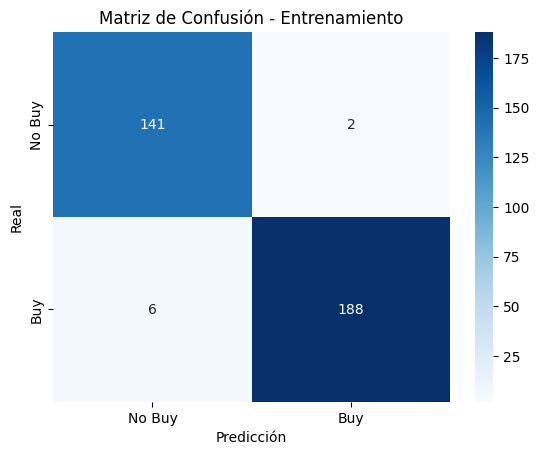

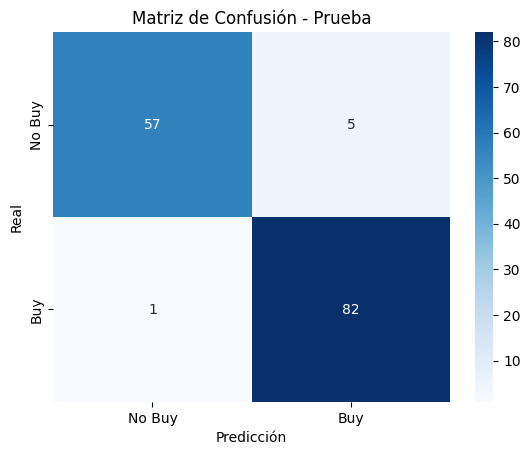

In [21]:
# Entrenar
model_pipeline.fit(X_train, y_train)

# Predicciones
y_pred_train = model_pipeline.predict(X_train)
y_pred_test = model_pipeline.predict(X_test)

# Reporte de métricas
print("🔹 Entrenamiento:")
print(classification_report(y_train, y_pred_train))

print("🔹 Prueba:")
print(classification_report(y_test, y_pred_test))

# Matriz de confusión
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Buy", "Buy"], yticklabels=["No Buy", "Buy"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(title)
    plt.show()

plot_conf_matrix(y_train, y_pred_train, "Matriz de Confusión - Entrenamiento")
plot_conf_matrix(y_test, y_pred_test, "Matriz de Confusión - Prueba")


### Conclusión - Parte 1

El modelo de Regresión Logística logró resultados sólidos para predecir señales de trading (Buy / No Buy) utilizando indicadores técnicos y variables categóricas relacionadas con el contexto económico.

La métrica de F1-score alcanzó 0.98 en entrenamiento y 0.96 en prueba, indicando buena generalización. La tasa de falsos positivos y negativos es baja, lo cual es crucial en entornos financieros (y en todo testing) donde las decisiones incorrectas implican costos.

El uso de `SMOTE` fue clave para evitar sesgos hacia la clase mayoritaria.


### 📊Parte 2: Reducción de Dimensionalidad + Optimización

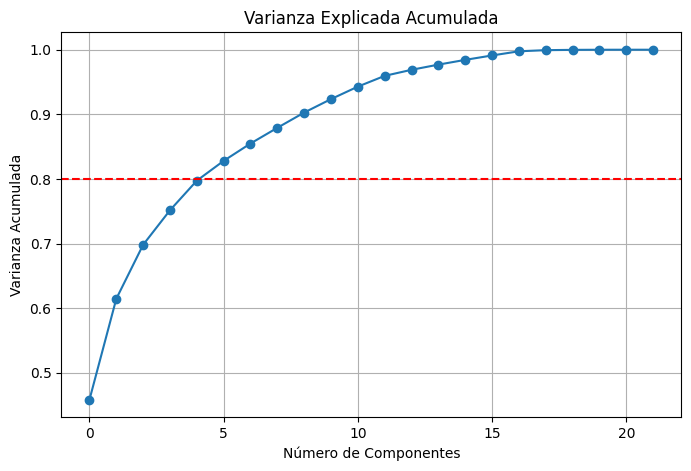

Se requieren 6 componentes para explicar al menos el 80% de la varianza.


In [23]:
# Aplicamos solo el preprocesamiento al conjunto de entrenamiento
X_train_transformed = preprocessor.fit_transform(X_train)

# PCA sin reducción todavía, solo para explorar
pca = PCA().fit(X_train_transformed)

# Varianza acumulada
import numpy as np
import matplotlib.pyplot as plt

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Gráfica de varianza explicada
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=0.80, color='r', linestyle='--')
plt.title("Varianza Explicada Acumulada")
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Acumulada")
plt.grid(True)
plt.show()

# Mostrar número de componentes que explican al menos 80%
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
print(f"Se requieren {n_components_80} componentes para explicar al menos el 80% de la varianza.")


### Creación del Pipeline incluyendo PCA

In [24]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA

# Pipeline actualizado
pipeline_pca = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("pca", PCA(n_components=6)),
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(max_iter=1000, solver='liblinear'))
])

# Hiperparámetros a buscar
param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__penalty": ["l1", "l2"]
}

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
grid_search = GridSearchCV(
    pipeline_pca,
    param_grid=param_grid,
    cv=cv,
    scoring="f1",
    verbose=1,
    n_jobs=-1
)

# Entrenar
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parámetros: {'classifier__C': 10, 'classifier__penalty': 'l1'}


### ⊧ Comparativa de ámbos modelos 

🔹 Entrenamiento (PCA):
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       143
           1       0.98      0.98      0.98       194

    accuracy                           0.98       337
   macro avg       0.98      0.98      0.98       337
weighted avg       0.98      0.98      0.98       337

🔹 Prueba (PCA):
              precision    recall  f1-score   support

           0       0.95      0.94      0.94        62
           1       0.95      0.96      0.96        83

    accuracy                           0.95       145
   macro avg       0.95      0.95      0.95       145
weighted avg       0.95      0.95      0.95       145



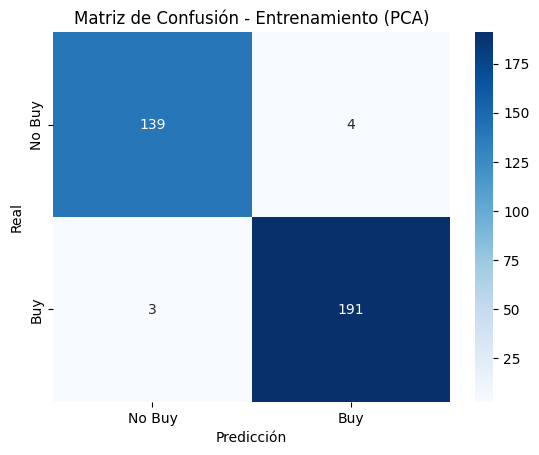

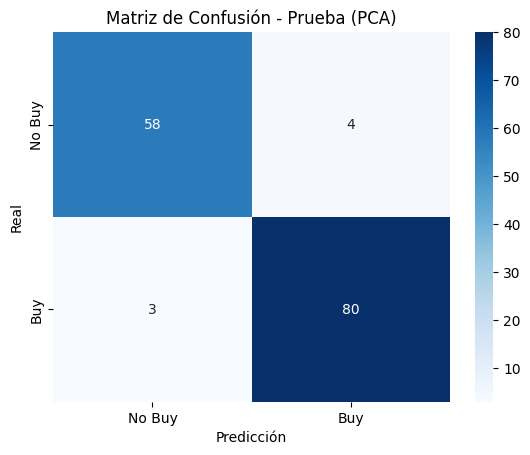

In [25]:
# Mejor modelo
best_model = grid_search.best_estimator_

# Predicciones
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Reporte de métricas
print("🔹 Entrenamiento (PCA):")
print(classification_report(y_train, y_pred_train))

print("🔹 Prueba (PCA):")
print(classification_report(y_test, y_pred_test))

# Matrices de confusión
plot_conf_matrix(y_train, y_pred_train, "Matriz de Confusión - Entrenamiento (PCA)")
plot_conf_matrix(y_test, y_pred_test, "Matriz de Confusión - Prueba (PCA)")


### 🧠 Comparación entre Modelo Base y Modelo con PCA + Optimización

| Métrica      | Parte 1 (Modelo Base) | Parte 2 (PCA + Optimización) |
|--------------|------------------------|-------------------------------|
| **Accuracy** | 0.96                   | 0.95                          |
| **F1-score** | 0.96                   | 0.96                          |
| **Precision**| 0.94                   | 0.95                          |
| **Recall**   | 0.99                   | 0.96                          |
| **Falsos Positivos (FP)** | 5        | 4                             |
| **Falsos Negativos (FN)** | 1        | 3                             |

📌 *Ambos modelos tuvieron un rendimiento excelente, aunque el uso de PCA y GridSearchCV mantuvo un rendimiento competitivo con menor cantidad de componentes.*

🔍 Observaciones:
- Ambos modelos generalizan muy bien.

- El modelo con PCA tiene ligera pérdida en Recall (Buy): aumentaron los falsos negativos.

- L1 con C=10 resultó en buen rendimiento sin overfitting.

- El PCA reduce la dimensionalidad y puede facilitar despliegue, aunque el costo fue menor en precisión.

### Parte 3: Análisis de métricas en el contexto financiero

1. 📉 ¿Impacto de los falsos positivos y negativos?

- Falsos Positivos (FP) = El modelo predice Buy pero no debía comprar → El portafolio podría comprar en un mal momento → riesgo de pérdida.

- Falsos Negativos (FN) = El modelo predice No Buy pero sí debía comprar → Se pierde una oportunidad de ganancia.

 Sabemos que en nuestro contexto, FP suele ser más costoso porque implica pérdidas reales. Los FN duelen, pero no afectan el capital directamente.

2. 🎯 ¿Qué métrica debe priorizar la firma? --> Depende del perfil de riesgo:

- *Si* la firma prefiere evitar pérdidas → prioriza Precision

Evita falsos positivos: sólo compra cuando esté muy segura.

- *Si* la firma quiere capturar todas las oportunidades → prioriza Recall

Prefiere equivocarse comprando de más, antes que dejar pasar una oportunidad.

➡️ En muchos casos, el F1-score es la métrica equilibrada ideal.

### 📌 Conclusión general

Durante el desarrollo de este **`proyecto`**, como equipo tuvimos la oportunidad de construir paso a paso un pipeline completo de machine learning para predecir señales de trading en el ETF SPY. La experiencia nos permitió reforzar no solo conceptos técnicos, sino también entender mejor cómo se comportan los modelos frente a datos financieros reales.

Uno de los mayores retos fue encontrar el equilibrio entre un modelo que sea preciso, pero que al mismo tiempo no sobreajuste ni dependa de demasiadas variables. Fue ahí donde aplicar técnicas como SMOTE para el balanceo de clases, o PCA para reducir dimensionalidad, resultaron fundamentales. La exploración de los indicadores técnicos también fue clave para enriquecer nuestras features desde el inicio.

Lo que más resaltó fue ver cómo incluso con un modelo sencillo como la regresión logística, se puede lograr un desempeño robusto si se estructura correctamente el pipeline. Los resultados hablaron por sí mismos: altos valores de F1-score, baja cantidad de errores, y un modelo que generaliza bien. Nos llevamos no solo un aprendizaje técnico, sino también una base sólida para futuros proyectos de predicción financiera.

